#### Teoría de Circuitos II

# Tarea Semanal 9

#### Por Nahuel Braian Contreras

### Parte I - Diseño de Filtro IIR

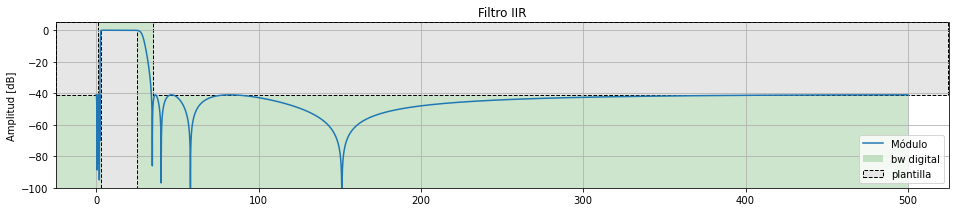

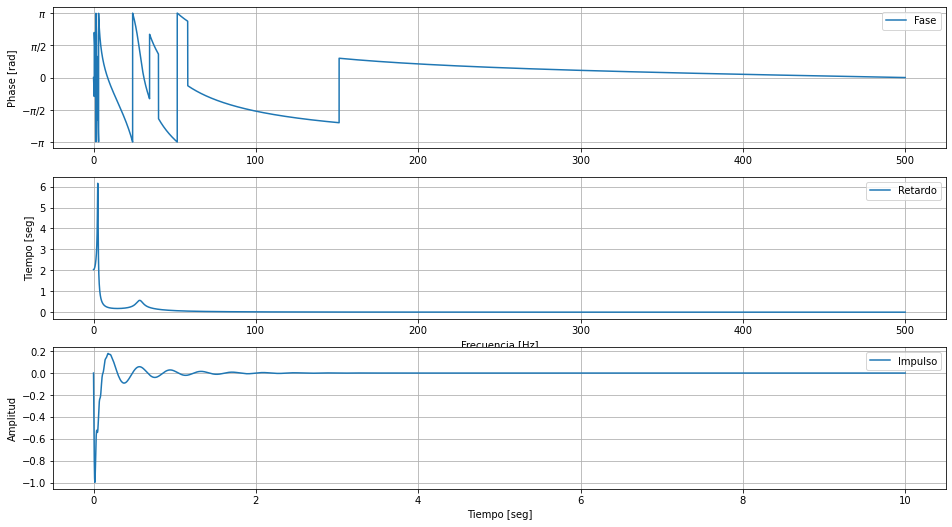

In [17]:
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
from splane import plot_plantilla
import scipy.io as sio

def group_delay(ww, phase):
    
    groupDelay = -np.diff(phase)/np.diff(ww)
    
    return(np.append(groupDelay, groupDelay[-1]))

fs = 1000 # Hz
nyq_frec = fs / 2

len_zeros = int(10e3)

ripple = 0.1 # dB
alfa_max = 41 # dB
worN=int(5*10e3)

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-alfa_max, -alfa_max, -ripple, -ripple, -alfa_max, -alfa_max])
gains = 10**(gains/20)

bp_sos_iir = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple, alfa_max, False, 'cheby2', 'sos', fs)

w,h = sig.sosfreqz(bp_sos_iir,worN,False,fs)

t, y_out = sig.impulse(sig.sos2zpk(bp_sos_iir)) #diverge el impulso (revisar)

gd = group_delay(w,np.angle(h))

# hago este for para poder borrar los sobrepicos erroneos del retardo de grupo
for i in range(len(gd)-1):
    if (gd[i] > 10) or ( gd[i] < 0): # si detecto esos sobrepicos ficticios
        # realizo un promedio de la muestra anterior y la futura
        gd[i] = (gd[i-1] + gd[i+1])/2  

# Respuesta al impulso
# La armo por definicion, ya que la funcion de python anda mal
impulso = np.zeros(len_zeros)
impulso[0] = 1
respuesta_impulso = sig.sosfiltfilt(bp_sos_iir, impulso)
tt = np.arange(len_zeros)

plt.subplot(4, 1, 1)
plt.gcf().set_size_inches(16, 14)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db,label='Módulo')
plt.ylabel('Amplitud [dB]')
plt.title('Filtro IIR')
plt.ylim(-100, 5)
plt.grid(True)
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = alfa_max, fs = fs)


plt.subplot(4, 1, 2)
plt.gcf().set_size_inches(16, 12)
plt.plot(w, np.angle(h),label='Fase')
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
            [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 3)
plt.gcf().set_size_inches(16, 12)
plt.plot(w,gd,label='Retardo')
plt.ylabel('Tiempo [seg]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(10*tt/len(tt),respuesta_impulso,label='Impulso')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [seg]')
plt.grid(True)
plt.legend()

### Diseño de Filtro FIR

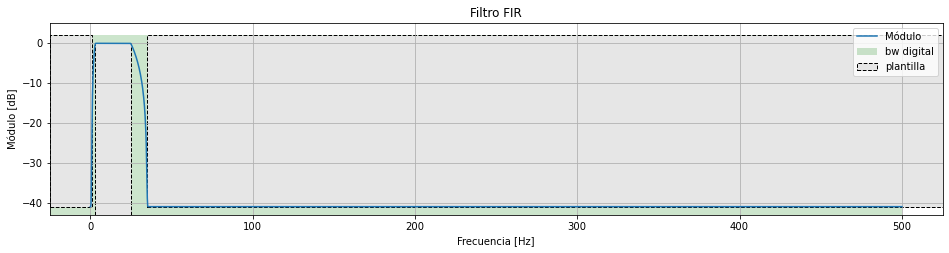

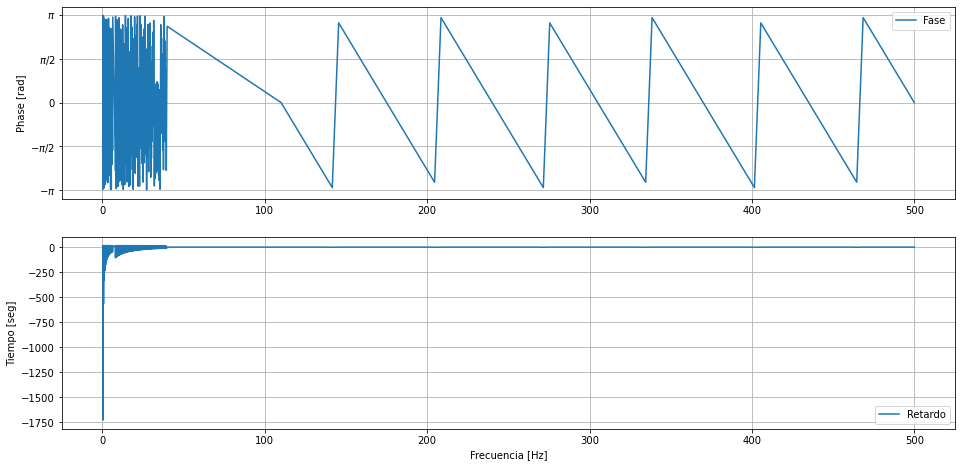

In [16]:
cant_coeficientes = 4601

fir_bp = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, FIR_filter = sig.freqz(fir_bp, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

db_fir = 20*np.log10(np.maximum(np.abs(FIR_filter), 1e-5))

gd = group_delay(w,np.angle(FIR_filter))


plt.subplot(3, 1, 1)
plt.gcf().set_size_inches(16, 12)
plt.plot(w, db_fir, label='Módulo')
plt.title('Filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.legend()
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = alfa_max, fs = fs)


plt.subplot(3, 1, 2)
plt.gcf().set_size_inches(16, 12)
plt.plot(w, np.angle(FIR_filter),label='Fase')
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
            [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
# plt.xlim(lim1, lim2)
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.gcf().set_size_inches(16, 12)
plt.plot(w,gd,label='Retardo')
plt.ylabel('Tiempo [seg]')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.legend()

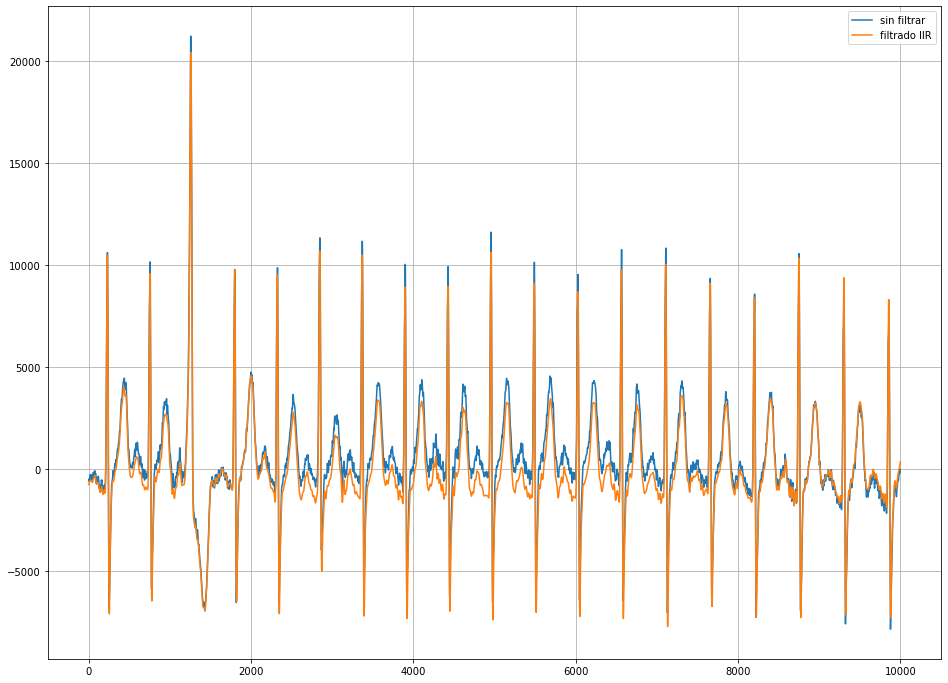

In [28]:
mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']


## redefino el filtro IIR ya que al hacer filtfilt, aplico doblemente las restricciones
ripple = 0.05 # dB
alfa_max = 20 # dB
wN=int(5*10e3)

ws1 = 0.25 #Hz
wp1 = 0.75 #Hz
wp2 = 30 #Hz
ws2 = 50 #Hz

len_zeros = int(10e3)

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-alfa_max, -alfa_max, -ripple, -ripple, -alfa_max, -alfa_max])
gains = 10**(gains/20)

bp_sos_iir = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple, alfa_max, analog=False,ftype= 'cheby2', output='sos', fs=fs)

# aplico el filtro a mi se;al de ECG

signal_filter = sig.sosfiltfilt(bp_sos_iir, ecg_one_lead, axis = 0)


ECG_antes = ecg_one_lead[450000:460000]
ECG_reposo_ejercicio_fitrado = (signal_filter[450000:460000])

plt.gcf().set_size_inches(16, 12)
plt.plot(ECG_antes, label = 'sin filtrar')
plt.plot(ECG_reposo_ejercicio_fitrado, label = 'filtrado IIR')
plt.grid(True)
plt.legend()